Group 11

Luis Miguel Arevalo Östberg

Alexandra Garcia Nilsson

Mattias Rydström

First we run all the import used in the code:

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import Sequential, applications
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

#### Introduction: Loading images from a directory

In [ ]:
data_gen = ImageDataGenerator(rescale=1.0/255)

In [ ]:
imgdir = 'a5_images' 
img_size = 64
batch_size = 32

train_generator = data_gen.flow_from_directory(
        imgdir + '/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

Found 1600 images belonging to 2 classes.


In [ ]:
Xbatch, Ybatch = train_generator.next()
Xbatch.shape
Ybatch[0]

1.0

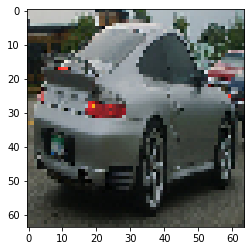

In [ ]:
plt.imshow(Xbatch[0])

#### Part 1: Training a convolutional neural network

We will in this taks train a convolutional neural network to decide whether an image contains a car or not.

Neural networks can get stuck in local minima and have problems with "plateaus" and therefore it's a good idéa to have random initializations. We have chosen to set the seed to a number, 12345, so that the initialization will be random in the same way for reproducibility.
 
Instead of going through all the data one by one in the regularizer, we choose to have a batch size of 32, which has been defined above.

In [ ]:
val_generator = data_gen.flow_from_directory(
        imgdir + '/validation',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345, 
        shuffle=True)

Found 576 images belonging to 2 classes.


We use 2D convolutional and max pooling layers since we are working with 2D images. While the images themselves are 2-dimensional, their data is represented by a 3D matrix, where the third dimension corresponds to each of the 3 RGB channels. We are using 32 and 64 filers in our convolutional layers and a Rectified Linear Unit (relu) as our activation function. The relu is commonly used, since it has no "plateau" on the positive side and would not get "stuck". The kernels are of 2X2 and then we move 2X2 steps at the time.
 
We use maxpooling for the pooling layers, which is the most commonly used. It simply takes the maximum value in a certain region. Here we have chosen a region of 2X2 and that it moves by 2X2 spaces each time.
 
Since we're working with a binary classifier - car or not car - we have one class in the output layer and use the sigmoid/logistic activation function.
 
We choose to keep Adam as our optimizer, since it is the most popular of the ones which has an adaptive learning rate depending on the shape of the function at the current evaluation. Finally, we choose the log loss function given the binary nature of the classification problem. We choose to use accuracies for evaluations and since the data is balanced the accuracies could be compared with 0.5 as a baseline.

In [ ]:
def make_convnet():

    input_shape = (img_size, img_size, 3)

    model = Sequential([
        Conv2D(32, (2, 2), (2, 2), activation='relu', input_shape=input_shape),# 2D general for images, 32 filters. relu is commonly used. Has no platteu on the positive side. 
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)), # Pooling also 2D for images and maxpooling the most commonly used pooling generally. 
        Conv2D(64, (2, 2), (2, 2), activation='relu'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Flatten(), # Keras technicality: from multidim to line up dimensions
        Dense(100, activation='relu'), # Ordinary NN layer. 
        Dense(1, activation='sigmoid') # Ordinary NN layer, Output-layer. Since binary: Num classes = 1 and activation = sigmoid/logistic
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc') # Keep the Adam and choose LogLoss. 

    return model

We choose to run for 100 epochs but we also choose to include an early stopping, as a way to avoid overfitting. If the loss hasn't improved for 10 epochs we choose to quit. Importantly, we are also choosing to restore the weights from the best epoch, which seems odd that this is not the default option. This way, we always get back the model with the weights that led to the minimum validation loss.

In [ ]:
n_epochs = 100
patience = 10
model = make_convnet()
callback = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=1) # We specify that we look at the validation loss for the early stopping. We also choose to use the best weights, instead of the last weights as the predefined feature. 
history = model.fit(train_generator, epochs=n_epochs, validation_data=val_generator, callbacks=[callback]) # Save the values from each run as "history"

Epoch 1/100
50/50 [==============================] - 10s 189ms/step - loss: 0.7087 - acc: 0.5168 - val_loss: 0.6730 - val_acc: 0.5521
Epoch 2/100
50/50 [==============================] - 5s 94ms/step - loss: 0.6342 - acc: 0.6912 - val_loss: 0.6332 - val_acc: 0.6458
Epoch 3/100
50/50 [==============================] - 4s 82ms/step - loss: 0.5741 - acc: 0.6930 - val_loss: 0.5610 - val_acc: 0.7413
Epoch 4/100
50/50 [==============================] - 4s 78ms/step - loss: 0.5199 - acc: 0.7599 - val_loss: 0.5440 - val_acc: 0.7378
Epoch 5/100
50/50 [==============================] - 4s 81ms/step - loss: 0.4811 - acc: 0.7752 - val_loss: 0.5290 - val_acc: 0.7587
Epoch 6/100
50/50 [==============================] - 4s 81ms/step - loss: 0.4656 - acc: 0.7947 - val_loss: 0.5391 - val_acc: 0.7257
Epoch 7/100
50/50 [==============================] - 4s 81ms/step - loss: 0.4397 - acc: 0.7988 - val_loss: 0.5136 - val_acc: 0.7639
Epoch 8/100
50/50 [==============================] - 4s 80ms/step - loss: 

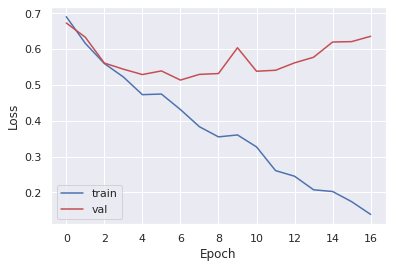

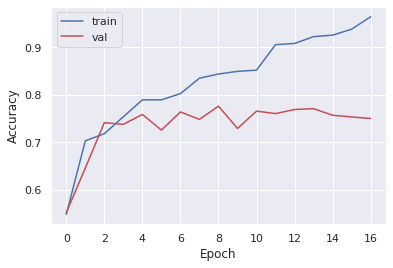

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['acc']
val_acc = history.history['val_acc']

sns.set_theme()

sns.lineplot(data=train_loss, color='b', label='train')
sns.lineplot(data=val_loss, color='r', label='val')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

sns.lineplot(data=train_acc, color='b', label='train')
sns.lineplot(data=val_acc, color='r', label='val')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [ ]:
val_loss, val_acc = model.evaluate(val_generator)
print(f'Best validation accuracy: {val_acc * 100:.2f}%')

18/18 [==============================] - 1s 47ms/step - loss: 0.5136 - acc: 0.7639
Best validation accuracy: 76.39%


We see that the loss is dropping for each epoch and the accuracies are rising for the train data, as expected. We seem to eventually run into overfitting for the validation data, though this was of course expected and the early stopping object takes care of that problem. Different runs yielded different values across epochs, however the qualitative result was always the same (first improving validation loss and accuracy, then worsening). The best accuracy score we get is 76.39%, so our model is better than the baseline of 50%, yet still not a very good model for deciding whether a picture contains a car or not. 

#### Part 2: Data augmentation

One additional way to reduce the risk of overfitting is to apply data augmentation. This means that we "tweak" the images in different ways and add these additional training instances while training. The tweaking should be large enough so that the new images differ from the original but should, at the same time, not be changed in a degree so it's impossible to decide whether there actually is a car or not in the image (in our example).

We make the same initial rescaling as before, so that the colour-values range up to 1 instead of 255. Then we also rotate the images with a random angle between 0 and 15 degrees, apply a sheer to distort the angels up to 20 percent, a zooming for randomly zooming inside pictures and do a horizontal flip, which flips 20 percent of the images on the horizon (not upside down since were not used to see cars upside down). Last we apply a width- and height shift, which shifts the image right/left vs up/down.

In [ ]:
data_gen2 = ImageDataGenerator(rescale=1.0/255, rotation_range=15, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, width_shift_range=0.2,
    height_shift_range=0.2)

train_generator2 = data_gen2.flow_from_directory(
    imgdir + '/train',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    classes=['other', 'car'],
    seed=12345,
    shuffle=True)

history = model.fit(train_generator2, epochs=n_epochs, validation_data=val_generator, callbacks=[callback])

Found 1600 images belonging to 2 classes.
Epoch 1/100
50/50 [==============================] - 6s 121ms/step - loss: 0.5223 - acc: 0.7381 - val_loss: 0.5217 - val_acc: 0.7517
Epoch 2/100
50/50 [==============================] - 6s 124ms/step - loss: 0.5212 - acc: 0.7544 - val_loss: 0.4950 - val_acc: 0.7656
Epoch 3/100
50/50 [==============================] - 6s 122ms/step - loss: 0.5155 - acc: 0.7525 - val_loss: 0.5352 - val_acc: 0.7361
Epoch 4/100
50/50 [==============================] - 6s 122ms/step - loss: 0.5159 - acc: 0.7500 - val_loss: 0.5170 - val_acc: 0.7587
Epoch 5/100
50/50 [==============================] - 6s 124ms/step - loss: 0.5149 - acc: 0.7500 - val_loss: 0.5090 - val_acc: 0.7604
Epoch 6/100
50/50 [==============================] - 6s 122ms/step - loss: 0.5060 - acc: 0.7581 - val_loss: 0.4995 - val_acc: 0.7587
Epoch 7/100
50/50 [==============================] - 6s 120ms/step - loss: 0.4993 - acc: 0.7619 - val_loss: 0.4755 - val_acc: 0.7951
Epoch 8/100
50/50 [========

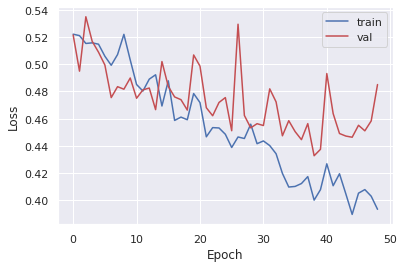

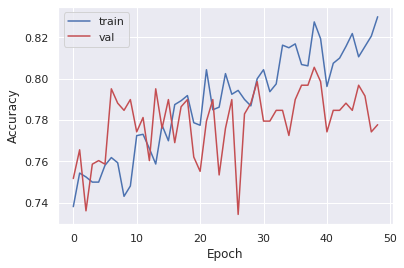

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['acc']
val_acc = history.history['val_acc']

sns.set_theme()

sns.lineplot(data=train_loss, color='b', label='train')
sns.lineplot(data=val_loss, color='r', label='val')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

sns.lineplot(data=train_acc, color='b', label='train')
sns.lineplot(data=val_acc, color='r', label='val')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [ ]:
val_loss, val_acc = model.evaluate(val_generator)
print(f'Best validation accuracy: {val_acc * 100:.2f}%')

18/18 [==============================] - 1s 47ms/step - loss: 0.4325 - acc: 0.8056
Best validation accuracy: 80.56%


We now obtain a validation accuracy score of 80.56%, which is slightly higher than the version without the data augmentation, with an accuracy of 76.04. We also see that the early stopping let the model run for close to 50 epochs, instead of just under 20 as before the augmentation. 

There is some volatility between runs, so we don't know if we can say that the run on the data with data augmentation is significantly better than the one without but for all the runs we have made, we got higher values on the runs with the augmentation than the runs without the augmentations. We have tried some hyperparametertuning but because of time management, we choose to not spend a lot of time on it. With a more rigorous work on the tuning of the parameters of the augmentation the differance between the run on the different training data sets would have likely been larger.   

#### Interlude: Applying a pre-trained convolutional neural network

In [ ]:
vggmodel = applications.VGG16(weights='imagenet', include_top=True)

553467904/553467096 [==============================] - 8s 0us/step


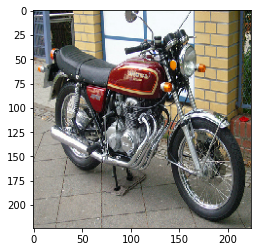

In [ ]:
img = load_img('a5_images/train/other/0000.jpg', target_size=(224,224))
sns.reset_orig()
plt.imshow(img)

img = img_to_array(img)
img = preprocess_input(img)
img = img.reshape(1, 224, 224, 3)

In [ ]:
preds = vggmodel.predict(img)
preds = decode_predictions(preds)
preds

40960/35363 [==================================] - 0s 0us/step


[[('n03785016', 'moped', 0.9190168),
  ('n03791053', 'motor_scooter', 0.067292474),
  ('n03208938', 'disk_brake', 0.013152323),
  ('n03127747', 'crash_helmet', 0.0002478774),
  ('n03792782', 'mountain_bike', 8.486692e-05)]]

#### Part 3: Using VGG-16 as a feature extractor

In [ ]:
feature_extractor = applications.VGG16(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))
vgg_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

58892288/58889256 [==============================] - 1s 0us/step


The function below takes 2 arguments: the path from which to load the images (training or validation) and the path (filename) to which to save the extracted features. The function loads the images and runs them through the data generator, passes them through the bottom layers of the pre-trained VGG16 model and saves the output (i.e. the extracted features) to the specified path. These features can then be loaded and used to train a separate classifier, as we do later on below.

In [ ]:
def create_vgg16_features(load_path, save_path):

    data_generator = vgg_data_gen.flow_from_directory(
        load_path,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=False)

    cnn_features = feature_extractor.predict(data_generator)

    with open(save_path, 'wb') as f:
        np.save(f, cnn_features)

And below we use the function to save our training and validation features.

In [ ]:
create_vgg16_features('a5_images/train', 'train_features')
create_vgg16_features('a5_images/validation', 'val_features')


Found 1600 images belonging to 2 classes.
Found 576 images belonging to 2 classes.


We use two functions below. One small that was given to us in the assignment that help us get the output labels. And then the main train_on_cnnfeatures that takes the directories from the code above, and first reshape the data, and then we use a random forst classifier to train on the data and predict our validation data. We print the accucary, and output the trained model, so that if we want to run other tests on new data, we don't need to train the model again.

In [ ]:
def get_labels(n):
    return np.array([0]*(n//2) + [1]*(n//2))

def train_on_cnnfeatures(train_dirr, val_dirr):
    with open(train_dirr, 'rb') as f: #These two opens get the saved data from the file directories we inputed in the function.
        train_data = np.load(f)
    with open(val_dirr, 'rb') as f:
        val_data = np.load(f)

    x_train = np.reshape(train_data, (train_data.shape[0], -1)) #Reshape the data so that we can use it with our RFC
    x_val = np.reshape(val_data, (val_data.shape[0], -1))

    y_train, y_val = get_labels(1600), get_labels(576)

    clf = RandomForestClassifier(n_estimators=200) #Create a random forest classifier that have 200 trees.

    clf.fit(x_train, y_train) #Train the model on the data

    y_pred = clf.predict(x_val) #Predict our validation data.

    acc = accuracy_score(y_val, y_pred)

    print(f'Validation accuracy: {acc * 100:.2f}%')

    return clf #Returns the trained model. 

train_directory = 'train_features'
val_directory = 'val_features'

trained_clf = train_on_cnnfeatures(train_directory, val_directory)

Validation accuracy: 89.41%


We get a substantial increase in validation accuracy when using the bottom layers of the VGG16 model as a feature extractor. The features obtained by running our images through the VGG16 network are then used on our own classifier, in this case a random forest, which is then able to achieve higher validation accuracies than our previous CNN could.

The work that the VGG16 model is doing here is essentially using its pre-trained convolutional layers and filters to identify which of its pre-trained features are present in our data. For purposes of our random forest classifier we can even think of this as part of a highly involved data preprocessing step where we convert raw images to some features (pre-identified by the VGG16 model). Having identified the presence of these features in our data, the task of classifying it becomes evidently simpler.

The key take-away here is that we can use transfer learning to extract those features that are relevant in our image data (and likely this extends to some other forms of data as well) in order to have a representation that is more useful and informative when used for classification.

#### Part 4: Visualizing the learned features

Below we get the pre-trained models first layer of convolutional filters, and visualize the first 10 of them. For each filter, we visualize the positive (left) and negative (right) parts. This tells us what patterns in the image activate the filter (positive) and which patterns in the data deactivate the filter (negative).

In [ ]:
first_layer_weights = vggmodel.get_weights()[0]
first_layer_weights.shape

(3, 3, 3, 64)

In [ ]:
def kernel_image(weights, i, positive):
    
    # extract the convolutional kernel at position i
    k = weights[:,:,:,i].copy()
    if not positive:
        k = -k
    
    # clip the values: if we're looking for positive
    # values, just keep the positive part; vice versa
    # for the negative values.
    k *= k > 0

    # rescale the colors, to make the images less dark
    m = k.max()
    if m > 1e-3:
        k /= m 

    return k


As can be seen in the output cell below, the positive-negative pairs exhibit an intuitive color and positional symmetry, where we can somewhat distinguish how the negative part of the filter is the opposite (both in color and orientation) of the positive part of the filter. The way we can interpret this is, when a given filter runs through a convolution and finds a pattern closely similar to its positive part, it lights up and becomes "enabled". This in turn makes this feature get a high positive value, which then gets fed as input to the next layer (probably a MaxPool, or another Conv2D). Conversely, if the filter finds a pattern closely similar to its negative part, it becomes "deactivated" and likely results in a highly negative value, which also gets fed as input into the next layer.

So for example, we can say that the first filter below detects green upper left corners, the fifth filter detects small light blue squares, the eighth filter detects light blue upper right corners, and so on.

Visualizing first 10 filters - positive (left) and negative (right) patterns...
Filter 1:


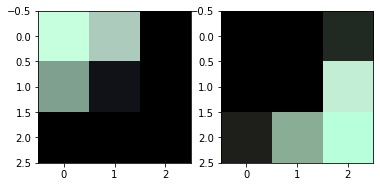

Filter 2:


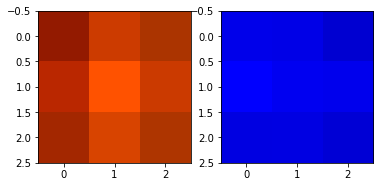

Filter 3:


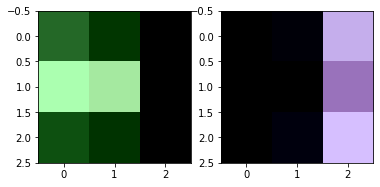

Filter 4:


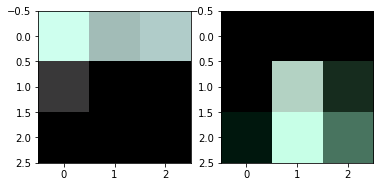

Filter 5:


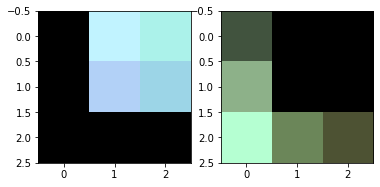

Filter 6:


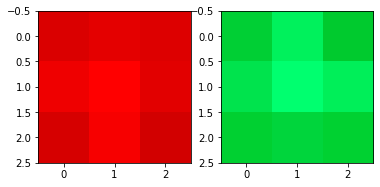

Filter 7:


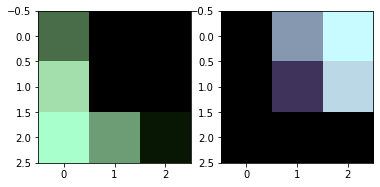

Filter 8:


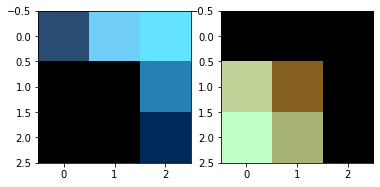

Filter 9:


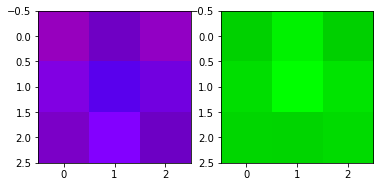

Filter 10:


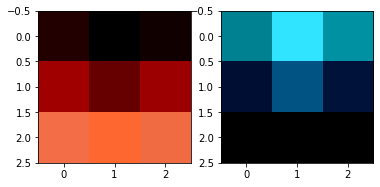

In [ ]:
n_filters = 10

print(f'Visualizing first {n_filters} filters - positive (left) and negative (right) patterns...')

for filter in range(n_filters):

    print(f'Filter {filter+1}:')
    plt.subplot(121)
    k = kernel_image(first_layer_weights, filter, True)
    plt.imshow(k)
    plt.subplot(122)
    k = kernel_image(first_layer_weights, filter, False)
    plt.imshow(k)
    plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b841557d-d7d5-45e1-a353-fa24c66e7564' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>